In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, TimeDistributed, GlobalAveragePooling1D, Masking
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
def convert_percentage_to_float(df, columns):
    for col in columns:
        df[col] = df[col].astype(str).str.rstrip('%')
        df[col] = pd.to_numeric(df[col], errors='coerce') / 100
        df[col] = df[col].round(3)
    return df

def convert_object_to_float(df, columns):
    for col in columns:
        df[col] = df[col].replace('-', 0)
        df[col] = pd.to_numeric(df[col], errors='coerce').astype(float)
    return df

def parse_duration(s):
    if isinstance(s, str) and ":" in s:
        mins, secs = s.split(":")
        return int(mins) * 60 + int(secs)
    return float(s) if s == s else None

In [4]:
df1 = pd.read_csv("players_stats.csv")
df2 = pd.read_csv("rosters.csv")
df_players = pd.merge(df1, df2[['Player', 'Season', 'Team']], on=['Player', 'Season'], how='left')

#df_players["Win rate"] = df_players["Win rate"].str.rstrip("%").astype(float) / 100
df_players.drop(columns=["Country"], inplace=True)
df_players = df_players[df_players["VSPM"] != "-"]
df_players = df_players[df_players["KDA"] != "-"]
#df_players['Solo Kills'] = df_players['Solo Kills'].replace('-', 0)
percentage_columns = ["Win rate", "KP%", "DMG%", "FB %", "FB Victim"]
object_columns = ["KDA", "Solo Kills"]
df_players = convert_percentage_to_float(df_players, percentage_columns)
df_players = convert_object_to_float(df_players, object_columns)
df_players.reset_index(drop=True, inplace=True)

df_players.head(10)

,Player,Season,Position,Games,Win rate,KDA,Avg kills,Avg deaths,Avg assists,CSM,...,Avg WCPM,Avg VWPM,GD@15,CSD@15,XPD@15,FB %,FB Victim,Penta Kills,Solo Kills,Team
0,ADD,S8,TOP,96,0.323,2.0,1.2,2.4,3.6,8.9,...,0.22,0.20,-80,-5,-181,0.198,0.198,0,11.0,MVP
1,Brook,S8,TOP,1,0.000,3.5,3.0,2.0,4.0,8.8,...,0.42,0.10,771,16,-38,1.000,0.000,0,0.0,Hanwha Life eSports
2,Crazy,S8,TOP,92,0.293,2.7,1.7,1.8,3.0,8.7,...,0.20,0.17,-92,1,-79,0.141,0.130,0,11.0,bbq Olivers
3,CuVee,S8,TOP,105,0.571,2.5,1.7,2.1,3.4,9.2,...,0.21,0.21,-86,-3,-41,0.181,0.114,0,19.0,Gen.G eSports
4,CuVee,S8,TOP,105,0.571,2.5,1.7,2.1,3.4,9.2,...,0.21,0.21,-86,-3,-41,0.181,0.114,0,19.0,KSV eSports
5,Khan,S8,TOP,83,0.699,3.8,2.4,1.7,4.1,9.6,...,0.25,0.23,240,7,159,0.229,0.120,1,19.0,Kingzone DragonX
6,Kiin,S8,TOP,106,0.613,3.9,2.2,1.5,3.8,9.7,...,0.20,0.16,147,4,135,0.198,0.132,0,23.0,Afreeca Freecs
7,Kiin,S8,TOP,106,0.613,3.9,2.2,1.5,3.8,9.7,...,0.20,0.16,147,4,135,0.198,0.132,0,23.0,Ever8 Winners
8,Lindarang,S8,TOP,90,0.522,2.6,1.8,2.2,3.9,8.6,...,0.13,0.13,22,-4,-134,0.322,0.144,0,9.0,Hanwha Life eSports
9,Lindarang,S8,TOP,90,0.522,2.6,1.8,2.2,3.9,8.6,...,0.13,0.13,22,-4,-134,0.322,0.144,0,9.0,ROX Tigers


In [5]:
df_teams = pd.read_csv("teams_stats.csv")

df_teams.drop(columns=["Region", "FOS%", "VGPG", "ATAKHAN%", "PPG"], inplace=True)
percentage_columns = ["Win rate"]
percentage = ["FB%", "FT%", "DRA%", "HER%", "NASH%"]
df_teams[percentage] = df_teams[percentage].apply(lambda x: x / 100)
df_teams[percentage] = df_teams[percentage].apply(lambda col: col.round(3))
df_teams = convert_percentage_to_float(df_teams, percentage_columns)
df_teams["Game duration"] = df_teams["Game duration"].apply(parse_duration)
df_teams = df_teams[~df_teams['Season'].isin(['S6', 'S7'])]
df_teams.reset_index(drop=True, inplace=True)

df_teams.head(10)

,Team,Season,Games,Win rate,K:D,GPM,GDM,Game duration,Kills / game,Deaths / game,...,DRA@15,TD@15,GD@15,NASHPG,NASH%,CSM,DPM,WPM,VWPM,WCPM
0,Afreeca Freecs,S8,106,0.613,1.26,1855,104,2220,9.6,7.6,...,0.49,0.1,355,1.02,0.595,36.9,1685,4.7,1.54,2.04
1,bbq Olivers,S8,92,0.293,0.81,1706,-165,2248,7.7,9.5,...,0.30,-0.3,-544,0.74,0.369,35.0,1563,4.2,1.39,1.66
2,DAMWON Gaming,S8,6,0.833,1.49,1866,178,2251,14.7,9.8,...,0.83,-0.2,-493,0.67,0.583,34.6,1954,3.5,1.49,1.65
3,Ever8 Winners,S8,6,0.333,0.67,1640,-259,2355,7.5,11.2,...,0.50,-0.5,-2183,0.50,0.222,35.2,1388,4.4,1.54,1.55
4,Gen.G eSports,S8,59,0.627,1.07,1805,94,2080,8.8,8.2,...,0.73,0.2,693,0.69,0.576,35.6,1668,3.4,1.49,1.67
5,Griffin,S8,62,0.645,1.61,1835,123,2162,11.1,6.8,...,0.45,-0.1,-35,0.82,0.641,36.3,1738,3.5,1.35,1.71
6,Hanwha Life eSports,S8,46,0.543,1.00,1781,30,2036,9.3,9.3,...,0.63,0.3,-75,0.76,0.617,34.3,1667,3.7,1.41,1.58
7,Jin Air Green Wings,S8,89,0.371,0.90,1744,-91,2308,8.3,9.3,...,0.57,-0.1,-347,0.62,0.385,36.2,1704,4.2,1.30,1.84
8,Kingzone DragonX,S8,94,0.691,1.36,1895,192,2115,11.0,8.1,...,0.72,0.3,734,0.91,0.691,37.1,1830,4.3,1.32,1.86
9,Kongdoo Monster,S8,51,0.255,0.65,1689,-246,2248,7.3,11.2,...,0.39,0.0,-696,0.63,0.286,35.1,1629,4.5,1.40,1.74


In [6]:
X = df_teams.drop(['Team', 'Season', 'Win rate'], axis=1)   # drop non-numeric and target columns
y = df_teams['Win rate']

# Split into 80% train and 20% test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

LinearRegression()

"\nxgb = XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=42)\nxgb.fit(X_train_scaled, y_train)\n"

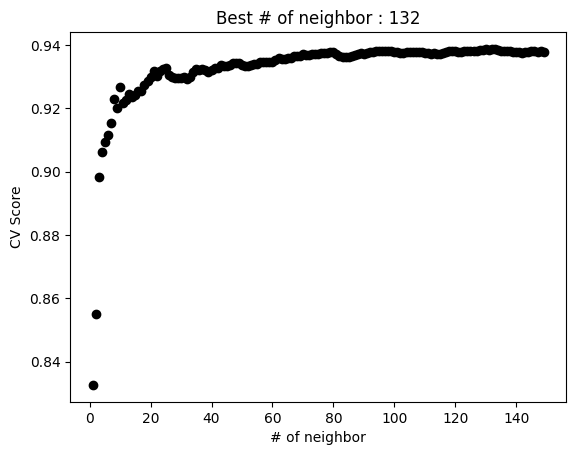

In [7]:
fig, ax = plt.subplots(1)
best_score = 0
for d in range(1,150):
    rf = RandomForestRegressor(n_estimators = d,random_state=42)
    cv_score = cross_val_score(rf, X_train_scaled, y_train, cv=10).mean()
    ax.scatter(d, cv_score, color = "black")
    if cv_score > best_score:
        best_n = d
        best_score = cv_score

l = ax.set(title = "Best # of neighbor : " + str(best_n),
       xlabel = "# of neighbor",
       ylabel = "CV Score")

rf = RandomForestRegressor(n_estimators = best_n, random_state=42)
rf.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

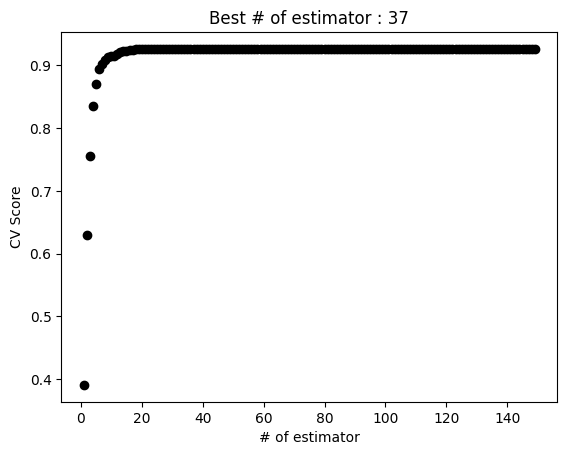

In [9]:
fig, ax = plt.subplots(1)
best_score = 0
for d in range(1,150):
    xgb = XGBRegressor(n_estimators=d, objective='reg:squarederror', random_state=42)
    cv_score = cross_val_score(xgb, X_train_scaled, y_train, cv=10).mean()
    ax.scatter(d, cv_score, color = "black")
    if cv_score > best_score:
        best_n = d
        best_score = cv_score

l = ax.set(title = "Best # of estimator : " + str(best_n),
       xlabel = "# of estimator",
       ylabel = "CV Score")


In [10]:
xgb = XGBRegressor(n_estimators=best_n, objective='reg:squarederror', random_state=42)
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=37, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [12]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='linear')  # linear output for regression
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train_scaled, y_train, epochs=100, validation_split=0.1, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
# Define a helper function to compute RMSE and R²
def evaluate_model(true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    return rmse, r2

# Evaluate Linear Regression
y_pred_lin = lin_reg.predict(X_test_scaled)
rmse_lin, r2_lin = evaluate_model(y_test, y_pred_lin)
print(f"Linear Regression: RMSE = {rmse_lin:.3f}, R^2 = {r2_lin:.3f}")

# Evaluate Random Forest
y_pred_rf = rf.predict(X_test_scaled)
rmse_rf, r2_rf = evaluate_model(y_test, y_pred_rf)
print(f"Random Forest:      RMSE = {rmse_rf:.3f}, R^2 = {r2_rf:.3f}")

# Evaluate XGBoost
y_pred_xgb = xgb.predict(X_test_scaled)
rmse_xgb, r2_xgb = evaluate_model(y_test, y_pred_xgb)
print(f"XGBoost:            RMSE = {rmse_xgb:.3f}, R^2 = {r2_xgb:.3f}")

# Evaluate Neural Network
y_pred_nn = model.predict(X_test_scaled).ravel()
rmse_nn, r2_nn = evaluate_model(y_test, y_pred_nn)
print(f"Neural Network:     RMSE = {rmse_nn:.3f}, R^2 = {r2_nn:.3f}")


Linear Regression: RMSE = 0.053, R^2 = 0.897
Random Forest:      RMSE = 0.055, R^2 = 0.891
XGBoost:            RMSE = 0.060, R^2 = 0.871
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Neural Network:     RMSE = 0.358, R^2 = -3.657



Linear Regression Coefficients:
          Feature  Coefficient
8     Towers lost    -0.047644
3             GDM     0.042084
7   Towers killed     0.039799
11          DRAPG    -0.028427
5    Kills / game     0.025063
12           DRA%     0.023824
17         NASHPG     0.017774
1             K:D     0.017371
0           Games    -0.015346
14         DRA@15     0.009265
15          TD@15    -0.008638
16          GD@15    -0.007723
2             GPM     0.007686
20            DPM    -0.007566
13           HER%     0.006052
19            CSM    -0.005300
9             FB%    -0.005116
22           VWPM     0.004555
18          NASH%    -0.002758
4   Game duration     0.002658
10            FT%    -0.002528
6   Deaths / game    -0.001645
23           WCPM     0.001231
21            WPM     0.000633


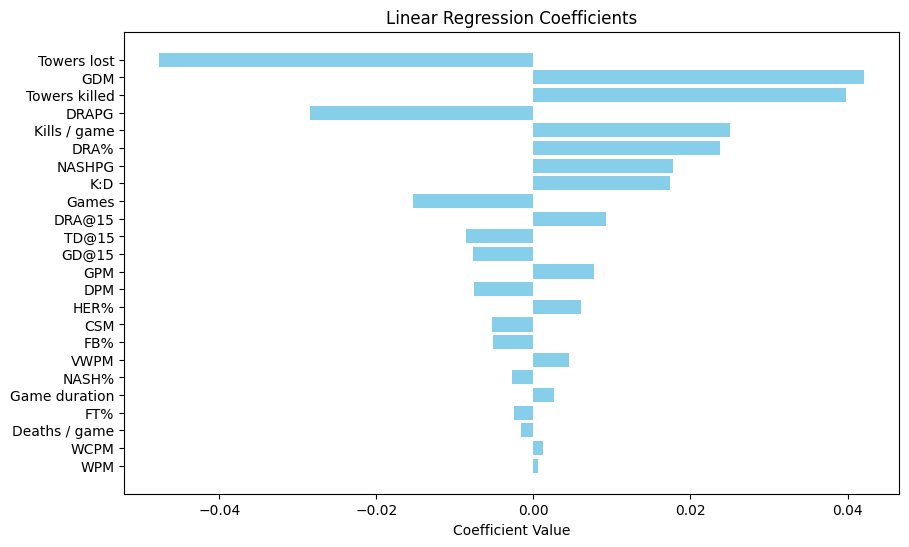

In [25]:
# (a) Linear Regression: Plot coefficients
importances_lin = lin_reg.coef_
features = X.columns
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': importances_lin})
coef_df = coef_df.sort_values(by='Coefficient', key=abs, ascending=False)
print("\nLinear Regression Coefficients:")
print(coef_df)

plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='skyblue')
plt.xlabel("Coefficient Value")
plt.title("Linear Regression Coefficients")
plt.gca().invert_yaxis()
plt.show()

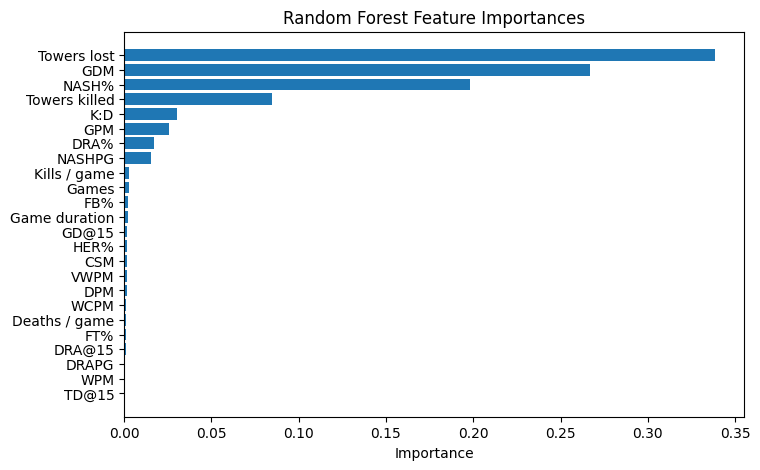

In [26]:
# (b) Feature Importance for Random Forest
importances_rf = rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]
top_features_rf = features[indices_rf]

plt.figure(figsize=(8, 5))
plt.barh(range(len(features)), importances_rf[indices_rf], align='center')
plt.yticks(range(len(features)), top_features_rf)
plt.xlabel("Importance")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.show()

In [20]:
new_X = X[["Towers lost","GDM","NASH%","K:D","DRA%","NASHPG","GPM","Kills / game"]]
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    new_X, y, test_size=0.2, random_state=42
)
scaler2 = StandardScaler()
X_train_scaled2 = scaler2.fit_transform(X_train2)
X_test_scaled2  = scaler2.transform(X_test2)

RandomForestRegressor(n_estimators=70, random_state=42)

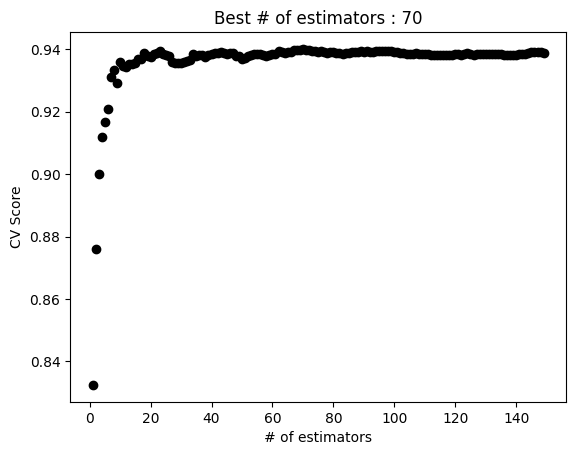

In [22]:
fig, ax = plt.subplots(1)
best_score = 0
for d in range(1,150):
    rf_new = RandomForestRegressor(n_estimators = d,random_state=42)
    cv_score = cross_val_score(rf_new, X_train_scaled2, y_train, cv=10).mean()
    ax.scatter(d, cv_score, color = "black")
    if cv_score > best_score:
        best_n = d
        best_score = cv_score

l = ax.set(title = "Best # of estimators : " + str(best_n),
       xlabel = "# of estimators",
       ylabel = "CV Score")

rf_new = RandomForestRegressor(n_estimators = best_n, random_state=42)
rf_new.fit(X_train_scaled, y_train)

In [23]:
y_pred_rf_new = rf_new.predict(X_test_scaled)
rmse_rf_new, r2_rf_new = evaluate_model(y_test, y_pred_rf_new)
print(f"Random Forest:      RMSE = {rmse_rf:.3f}, R^2 = {r2_rf:.3f}")

Random Forest:      RMSE = 0.055, R^2 = 0.891


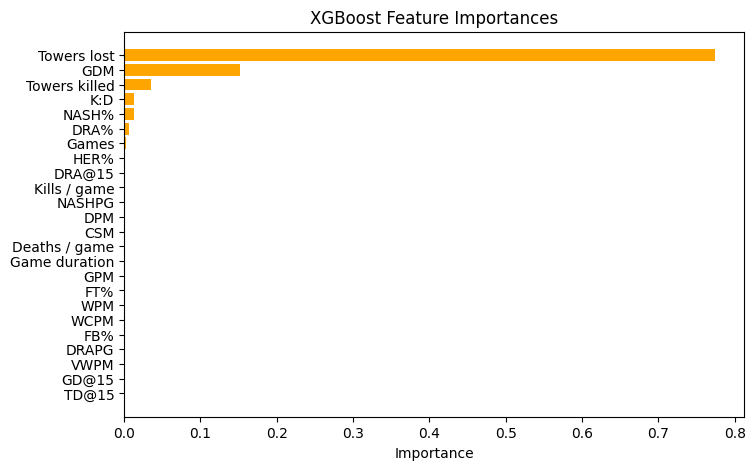

In [27]:
# (c) Feature Importance for XGBoost
importances_xgb = xgb.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1]
top_features_xgb = features[indices_xgb]

plt.figure(figsize=(8, 5))
plt.barh(range(len(features)), importances_xgb[indices_xgb], align='center', color='orange')
plt.yticks(range(len(features)), top_features_xgb)
plt.xlabel("Importance")
plt.title("XGBoost Feature Importances")
plt.gca().invert_yaxis()
plt.show()

In [86]:
new_X2 = X[["Towers lost","Towers killed","NASH%","K:D","DRA%"]]
X_train3, X_test3, y_train3, y_test3 = train_test_split(
    new_X2, y, test_size=0.2, random_state=42
)
scaler3 = StandardScaler()
X_train_scaled3 = scaler3.fit_transform(X_train3)
X_test_scaled3  = scaler3.transform(X_test3)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=11, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

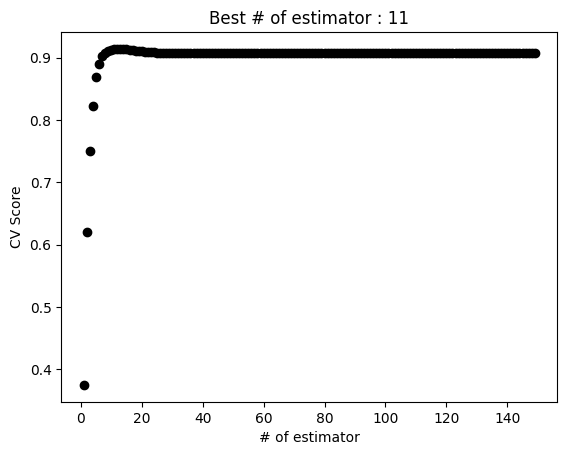

In [87]:
fig, ax = plt.subplots(1)
best_score = 0
for d in range(1,150):
    xgb2 = XGBRegressor(n_estimators=d, objective='reg:squarederror', random_state=42)
    cv_score = cross_val_score(xgb2, X_train_scaled3, y_train, cv=10).mean()
    ax.scatter(d, cv_score, color = "black")
    if cv_score > best_score:
        best_n = d
        best_score = cv_score

l = ax.set(title = "Best # of estimator : " + str(best_n),
       xlabel = "# of estimator",
       ylabel = "CV Score")
xgb2 = XGBRegressor(n_estimators=best_n, objective='reg:squarederror', random_state=42)
xgb2.fit(X_train_scaled3, y_train)

In [88]:
y_pred_xgb2 = xgb2.predict(X_test_scaled3)
rmse_xgb2, r2_xgb2 = evaluate_model(y_test, y_pred_xgb2)
print(f"XGBoost:            RMSE = {rmse_xgb:.3f}, R^2 = {r2_xgb:.3f}")

XGBoost:            RMSE = 0.060, R^2 = 0.871


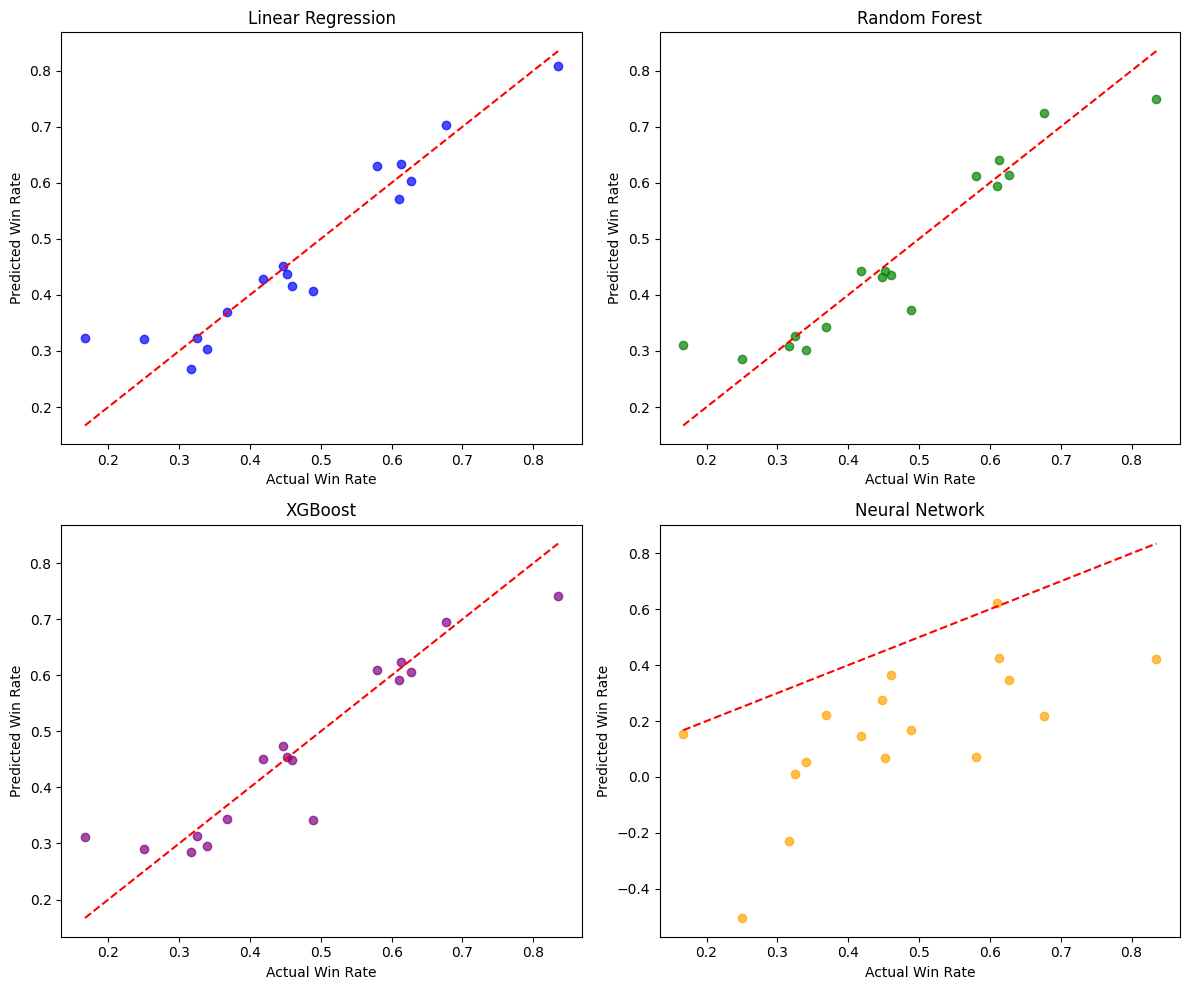

In [89]:
# (d) Predicted vs Actual Win Rates on Test Set (2x2 grid for the 4 models)
plt.figure(figsize=(12, 10))

# Linear Regression Plot
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred_lin, color='blue', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Linear Regression")
plt.xlabel("Actual Win Rate")
plt.ylabel("Predicted Win Rate")

# Random Forest Plot
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred_rf, color='green', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Random Forest")
plt.xlabel("Actual Win Rate")
plt.ylabel("Predicted Win Rate")

# XGBoost Plot
plt.subplot(2, 2, 3)
plt.scatter(y_test, y_pred_xgb, color='purple', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("XGBoost")
plt.xlabel("Actual Win Rate")
plt.ylabel("Predicted Win Rate")

# Neural Network Plot
plt.subplot(2, 2, 4)
plt.scatter(y_test, y_pred_nn, color='orange', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Neural Network")
plt.xlabel("Actual Win Rate")
plt.ylabel("Predicted Win Rate")

plt.tight_layout()
plt.show()

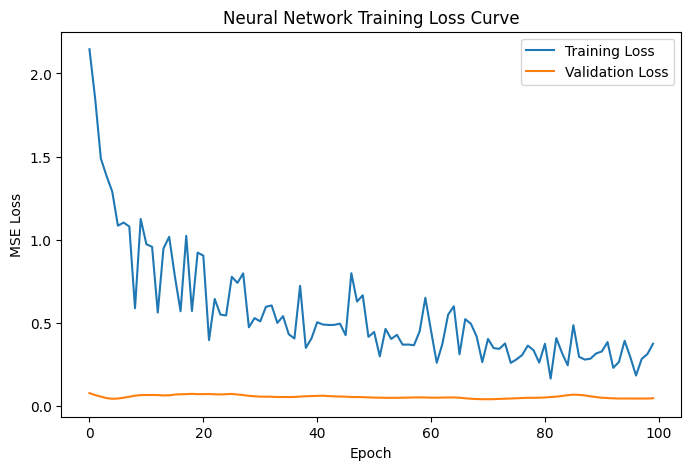

In [35]:
# (e) Neural Network Training Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Neural Network Training Loss Curve")
plt.legend()
plt.show()

In [63]:
y_player = X[["Towers lost","GDM","NASH%","K:D","DRA%","NASHPG","GPM","Kills / game"]]

In [36]:
df_players.head(10)

,Player,Season,Position,Games,Win rate,KDA,Avg kills,Avg deaths,Avg assists,CSM,...,Avg WCPM,Avg VWPM,GD@15,CSD@15,XPD@15,FB %,FB Victim,Penta Kills,Solo Kills,Team
0,ADD,S8,TOP,96,0.323,2.0,1.2,2.4,3.6,8.9,...,0.22,0.20,-80,-5,-181,0.198,0.198,0,11.0,MVP
1,Brook,S8,TOP,1,0.000,3.5,3.0,2.0,4.0,8.8,...,0.42,0.10,771,16,-38,1.000,0.000,0,0.0,Hanwha Life eSports
2,Crazy,S8,TOP,92,0.293,2.7,1.7,1.8,3.0,8.7,...,0.20,0.17,-92,1,-79,0.141,0.130,0,11.0,bbq Olivers
3,CuVee,S8,TOP,105,0.571,2.5,1.7,2.1,3.4,9.2,...,0.21,0.21,-86,-3,-41,0.181,0.114,0,19.0,Gen.G eSports
4,CuVee,S8,TOP,105,0.571,2.5,1.7,2.1,3.4,9.2,...,0.21,0.21,-86,-3,-41,0.181,0.114,0,19.0,KSV eSports
5,Khan,S8,TOP,83,0.699,3.8,2.4,1.7,4.1,9.6,...,0.25,0.23,240,7,159,0.229,0.120,1,19.0,Kingzone DragonX
6,Kiin,S8,TOP,106,0.613,3.9,2.2,1.5,3.8,9.7,...,0.20,0.16,147,4,135,0.198,0.132,0,23.0,Afreeca Freecs
7,Kiin,S8,TOP,106,0.613,3.9,2.2,1.5,3.8,9.7,...,0.20,0.16,147,4,135,0.198,0.132,0,23.0,Ever8 Winners
8,Lindarang,S8,TOP,90,0.522,2.6,1.8,2.2,3.9,8.6,...,0.13,0.13,22,-4,-134,0.322,0.144,0,9.0,Hanwha Life eSports
9,Lindarang,S8,TOP,90,0.522,2.6,1.8,2.2,3.9,8.6,...,0.13,0.13,22,-4,-134,0.322,0.144,0,9.0,ROX Tigers


In [60]:
df_players_test = df_players.drop(columns=["Player"])
def weighted_agg(group, weight_col='Games', exclude_cols=None):
    """
    group: subset of df_players for a given (Team, Season, Role).
    weight_col: column to use as weight (number of games).
    exclude_cols: list of columns to exclude from weighting

    Returns a pd.Series where each entry is the weighted average of a numeric column.
    """
    if exclude_cols is None:
        exclude_cols = [weight_col]

    # Find numeric columns in this group
    numeric_cols = group.select_dtypes(include=[np.number]).columns

    # Build a dictionary of results
    results = {}
    total_weight = group[weight_col].sum()

    # Loop over numeric columns, skipping excluded columns
    for col in numeric_cols:
        if col not in exclude_cols:
            # Weighted average formula: sum(value_i * weight_i) / sum(weight_i)
            weighted_avg = (group[col] * group[weight_col]).sum() / total_weight
            results[f'weighted_{col}'] = weighted_avg

    return pd.Series(results)

# 2. Group the DataFrame and apply the aggregation function
df_weighted = (
    df_players
    .groupby(['Team', 'Season'])
    .apply(weighted_agg, weight_col='Games', exclude_cols=['Games','Win rate'])
    .reset_index()
)

<ipython-input-60-57e36fe18ab0>:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weighted_agg, weight_col='Games', exclude_cols=['Games','Win rate'])


In [61]:
df_weighted

,Team,Season,weighted_KDA,weighted_Avg kills,weighted_Avg deaths,weighted_Avg assists,weighted_CSM,weighted_GPM,weighted_KP%,weighted_DMG%,...,weighted_Avg WPM,weighted_Avg WCPM,weighted_Avg VWPM,weighted_GD@15,weighted_CSD@15,weighted_XPD@15,weighted_FB %,weighted_FB Victim,weighted_Penta Kills,weighted_Solo Kills
0,APK Prince,S9,6.180000,2.520000,1.880000,5.680000,6.260000,353.000000,0.658800,0.200000,...,0.850000,0.416000,0.284000,84.600000,0.000000,206.600000,0.371600,0.057200,0.000000,1.400000
1,Afreeca Freecs,S10,3.071625,1.755378,2.567735,5.845767,4.956522,303.572082,0.659389,0.161995,...,0.866957,0.352311,0.348879,-219.418764,-5.945080,-214.089245,0.251618,0.082334,0.000000,7.050343
2,Afreeca Freecs,S11,3.125054,1.816122,2.575599,6.218736,5.097386,313.601307,0.664122,0.166885,...,0.930131,0.383137,0.365338,72.738562,0.322440,29.128540,0.337403,0.076296,0.000000,11.189542
3,Afreeca Freecs,S8,4.775391,2.036465,1.469128,4.802237,7.910291,386.044743,0.690405,0.214157,...,0.877964,0.385145,0.288546,63.565996,-1.026846,8.436242,0.322125,0.084953,0.000000,7.436242
4,Afreeca Freecs,S9,2.798117,2.148536,2.649163,5.008368,6.460669,348.665272,0.639973,0.198774,...,0.791381,0.343849,0.310356,21.345188,0.569038,-16.320084,0.227906,0.104667,0.031381,10.307531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,Team Battlecomics,S8,3.540000,2.160000,2.300000,5.380000,7.220000,369.200000,0.691600,0.199800,...,0.742000,0.350000,0.292000,84.600000,3.000000,83.600000,0.288600,0.088800,0.000000,0.400000
78,Team Dynamics,S10,2.797500,1.848333,2.800833,5.745833,4.859167,306.450000,0.661000,0.172000,...,0.976500,0.364417,0.345333,-109.766667,0.558333,-80.058333,0.149892,0.133117,0.000000,4.600000
79,Team Dynamics,S9,2.612698,1.877778,2.761905,5.174603,6.393651,340.809524,0.678286,0.198270,...,0.723968,0.298254,0.234444,-317.603175,-2.539683,-126.650794,0.301524,0.095238,0.269841,1.888889
80,VSG,S9,2.191429,1.634286,2.702857,3.822857,6.611429,334.285714,0.689886,0.200143,...,0.691714,0.325429,0.252857,-42.857143,-0.314286,-30.685714,0.142971,0.142857,0.000000,0.485714


In [90]:
X_player = df_weighted.drop(columns=["Team","Season"])
X_train_ptt, X_test_ptt, y_train_ptt, y_test_ptt = train_test_split(
    X_player, y_player, test_size=0.2, random_state=42
)
scaler_ptt = StandardScaler()
Xtr_ptt_scaled = scaler_ptt.fit_transform(X_train_ptt)
Xte_test_scaled  = scaler_ptt.transform(X_test_ptt)

RandomForestRegressor(n_estimators=11, random_state=42)

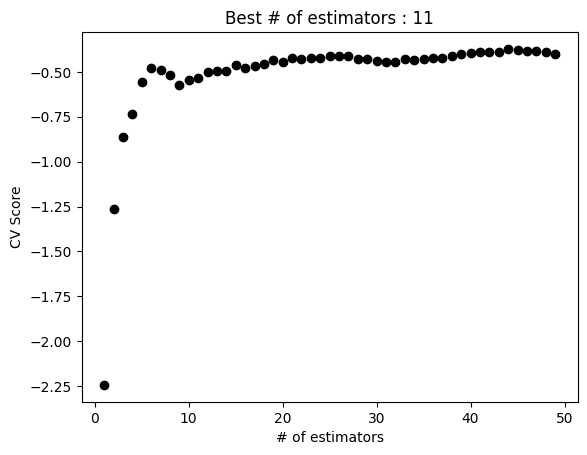

In [94]:
fig, ax = plt.subplots(1)
best_score = 0
for d in range(1,50):
    rf_ptt = RandomForestRegressor(n_estimators=d, random_state=42)
    cv_score = cross_val_score(rf_ptt, Xtr_ptt_scaled, y_train_ptt, cv=10).mean()
    ax.scatter(d, cv_score, color = "black")
    if cv_score > best_score:
        best_n = d
        best_score = cv_score

l = ax.set(title = "Best # of estimators : " + str(best_n),
       xlabel = "# of estimators",
       ylabel = "CV Score")

rf_ptt = RandomForestRegressor(n_estimators=best_n, random_state=42)
rf_ptt.fit(Xtr_ptt_scaled, y_train_ptt)

In [95]:
y_pred_rfptt = rf_ptt.predict(Xte_test_scaled)
rmse_rfptt, r2_rfptt = evaluate_model(y_test_ptt, y_pred_rfptt)
print(f"RF:            RMSE = {rmse_rfptt:.3f}, R^2 = {r2_rfptt:.3f}")

RF:            RMSE = 66.161, R^2 = -0.341


In [78]:
df_weighted_pos = (
    df_players
    .groupby(['Team', 'Season','Position'])
    .apply(weighted_agg, weight_col='Games', exclude_cols=['Games','Win rate'])
    .reset_index()
)

<ipython-input-78-acb5ee299649>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weighted_agg, weight_col='Games', exclude_cols=['Games','Win rate'])
